In [1]:
# Custom imports
from Generate_Problem import generate_problem
from HHL_Circuit import hhl_circuit
from Iterative_Refinement import norm_estimation, sign_estimation, IR
from Quantum_Linear_Solver import quantum_linear_solver

# Third-party libraries
import numpy as np
import pandas as pd

# Qiskit imports
import qiskit
import qiskit_aer

# PyTKet imports
import pytket
import qnexus as qnx
from pytket.extensions.nexus import NexusBackend
from pytket.extensions.nexus import QuantinuumConfig



# Filter warnings
# warnings.filterwarnings("ignore")

# Matplotlib inline to visualize plots
%matplotlib inline

# Use py310-qiskit1.0 environment

# Print library versions
print("Qiskit version (should be 1.3.0):", qiskit.__version__)
print("Qiskit Aer version (should be 0.15.1):", qiskit_aer.__version__)
print("Pytket version (should be 1.36.0):", pytket.__version__)

Qiskit version (should be 1.3.0): 1.4.0
Qiskit Aer version (should be 0.15.1): 0.16.1
Pytket version (should be 1.36.0): 1.40.0


In [8]:
pip install --upgrade pexpect jupyterlab_git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.7/367.7 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: pexpect
    Found existing installation: pexpect 4.8.0
    Uninstalling pexpect-4.8.0:
      Successfully uninstalled pexpect-4.8.0
  Attempting uninstall: jupyterlab_git
    Found existing installation: jupyterlab_git 0.50.0
    Uninstalling jupyterlab_git-0.50.0:
      Successfully uninstalled jupyterlab_git-0.50.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
problem = generate_problem(4, cond_number=5, sparsity=0.5, seed=1)
problem

{'A': array([[ 0.24, -0.  ,  0.  , -0.03],
        [-0.  ,  0.61,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.51, -0.  ],
        [-0.03,  0.  , -0.  ,  0.56]]),
 'b': array([ 0.26, -0.1 , -0.08, -0.17]),
 'csol': array([ 1.05243446, -0.16393443, -0.15686275, -0.24719101]),
 'condition_number': 2.571541615252496,
 'sparsity': 0.625,
 'eigs': array([0.23721179, 0.51      , 0.56278821, 0.61      ])}

In [3]:
# Create config object to specify details of desired backend
configuration = QuantinuumConfig(device_name='H2-2', attempt_batching=True)

# Set up a Nexus Project to compartmentalize running jobs and data
# Create a NexusBackend using our config and our retrieved project
backend = NexusBackend(configuration, project_name='HHL-IR')


Started using project with name: HHL-IR


In [4]:
A = problem['A']
b = problem['b']

# Single Run
solution = quantum_linear_solver(A, b, backend=backend, t0=2*np.pi, shots=1024)
solution

Running on H2-2


{'cost': 0,
 'number_of_qubits': 7,
 'circuit_depth': 326,
 'total_gates': 508,
 'two_qubit_gates': 166,
 'result_handle': ResultHandle('26cbe195-5ad2-4ae5-b84c-e0d895044544', 3142155),
 'runtime': datetime.timedelta(seconds=34, microseconds=983054),
 'x': array([ 0.35582221, -0.72508694, -0.32094282, -0.4946061 ]),
 'two_norm_error': 0.9424952359630967,
 'residual_error': 0.404402057654225}

In [5]:
status = backend.circuit_status(solution['result_handle'])
status

CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='Circuit has completed.', error_detail=None, completed_time=datetime.datetime(2025, 3, 24, 8, 42, 13, 900919, tzinfo=datetime.timezone.utc), queued_time=datetime.datetime(2025, 3, 24, 7, 44, 39, 147750, tzinfo=datetime.timezone.utc), submitted_time=datetime.datetime(2025, 3, 24, 7, 40, 42, 641916, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 3, 24, 8, 41, 38, 917865, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)

Iteration: 1
Running on H2-2
residual: 0.24109446929435854
error: 0.9232744408761744
alpha: 0.41354670312947533

Iteration: 2
Running on H2-2
residual: 0.19961857902495592
error: 0.82491849227812
alpha: 0.5018936902271768

Iteration: 3
Running on H2-2
residual: 0.1838293207101793
error: 0.748070390753803
alpha: 0.6140627609503694

Iteration: 4
Running on H2-2
residual: 0.1570313500459975
error: 0.627698205547794
alpha: 1.077594049504362

Iteration: 5
Running on H2-2
residual: 0.12787820110384945
error: 0.5236838497720483
alpha: 1.1894142748185066



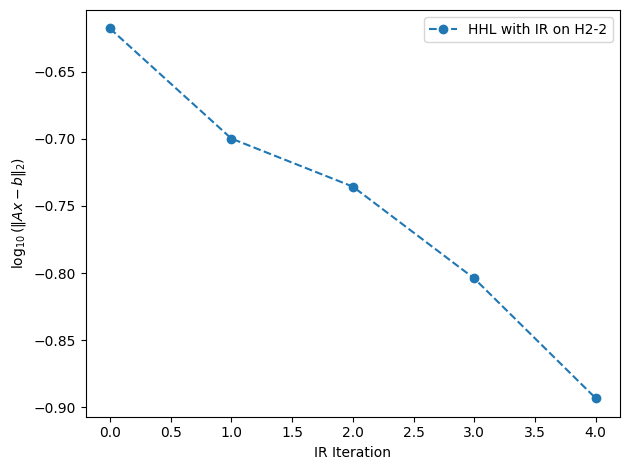

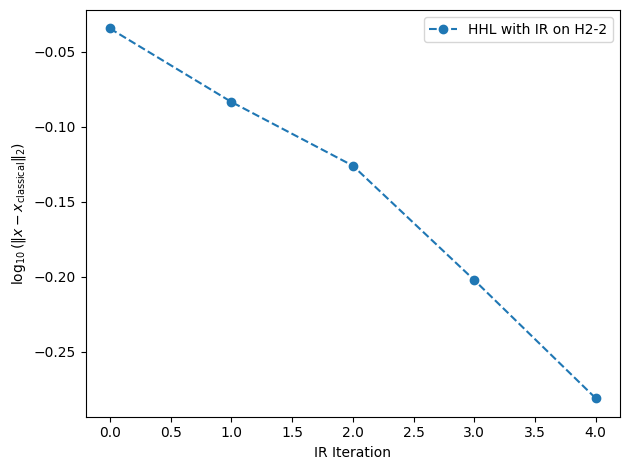

{'refined_x': array([ 0.53727284, -0.12830108, -0.1206985 , -0.32641031]),
 'residuals': [0.24109446929435854,
  0.19961857902495592,
  0.1838293207101793,
  0.1570313500459975,
  0.12787820110384945],
 'errors': [0.9232744408761744,
  0.82491849227812,
  0.748070390753803,
  0.627698205547794,
  0.5236838497720483],
 'total_iterations': 5,
 'total_cost': 0}

In [6]:
# Iterative Refinement
refined_solution = IR(A, b, precision=1e-5, max_iter=5, backend=backend, plot=True)
refined_solution

In [7]:
df = pd.DataFrame()
# Make a dataframe out of the results
datarow = {
    "Backend": backend.backend_config.device_name,
    "Problem Size": f"{len(b)} x {len(b)}",
    "A": problem["A"],
    "b": problem["b"],
    "Condition Number": problem["condition_number"],
    "Sparsity": problem["sparsity"],
    "Number of Qubits": solution["number_of_qubits"],
    "Circuit Depth": solution["circuit_depth"],
    "Total Gates": solution["total_gates"],
    "Two-Qubit Gates": solution["two_qubit_gates"],  # Uncomment if needed
    # "Runtime": solution["runtime"],  # Uncomment if needed
    "||x_c - x_q|| without IR": solution["two_norm_error"],
    "||x_c - x_q|| with IR": refined_solution["errors"][-1],
    "||Ax - b|| without IR": solution["residual_error"],
    "||Ax - b|| with IR": refined_solution["residuals"][-1],
    "Total Iterations of IR": refined_solution["total_iterations"],
    # "Total Cost": refined_solution["total_cost"],
    "Error list": refined_solution["errors"],
    "Residual list": refined_solution["residuals"],
}
df = pd.concat([df, pd.DataFrame([datarow])], ignore_index=True)

# Display the DataFrame without showing "Error list" and "Residual list"
df_display = df.drop(columns=["Error list", "Residual list", "A", "b"])

df_display.style.hide(axis="index").format(precision=6).set_caption(f"{backend.backend_config.device_name} Results")

Backend,Problem Size,Condition Number,Sparsity,Number of Qubits,Circuit Depth,Total Gates,Two-Qubit Gates,||x_c - x_q|| without IR,||x_c - x_q|| with IR,||Ax - b|| without IR,||Ax - b|| with IR,Total Iterations of IR
H2-2,4 x 4,2.571542,0.625000,7,326,508,166,0.942495,0.523684,0.404402,0.127878,5
